<a href="https://colab.research.google.com/github/pranchalkumar001/leukemia-detection-model/blob/main/EfficientNetB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mehradaria/leukemia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pranchalkumar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mehradaria/leukemia


100%|██████████| 110M/110M [00:00<00:00, 1.38GB/s]

In [3]:
!nvidia-smi

Wed Sep 10 07:46:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

In [5]:
train_dir = "/content/leukemia/Segmented"

In [6]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% training, 20% validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


In [7]:


# Load pretrained ResNet50 without top layers
base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False   # freeze feature extractor

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(4, activation="softmax")(x)  # 4 classes

# Build model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
history = model.fit(train_gen, validation_data=val_gen, epochs=100)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.2831 - loss: 1.3984 - val_accuracy: 0.2958 - val_loss: 1.3568
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.3113 - loss: 1.3607 - val_accuracy: 0.3066 - val_loss: 1.3849
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 529ms/step - accuracy: 0.3363 - loss: 1.3660 - val_accuracy: 0.3436 - val_loss: 1.3366
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 542ms/step - accuracy: 0.3834 - loss: 1.3246 - val_accuracy: 0.1772 - val_loss: 1.3801
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 544ms/step - accuracy: 0.3641 - loss: 1.3227 - val_accuracy: 0.3344 - val_loss: 1.3294
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 81s 529ms/step - accuracy: 0.4147 - loss: 1.2797 - val_accuracy: 0.3236 - val_loss: 1.3390
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 45s 543ms/step - accuracy: 0.4104 - loss: 1.3017 - val_accuracy: 0.3436 - val_loss: 1.3497
Epoch 8/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 539ms/step - accuracy: 0.3882 - loss: 1.2941 - va

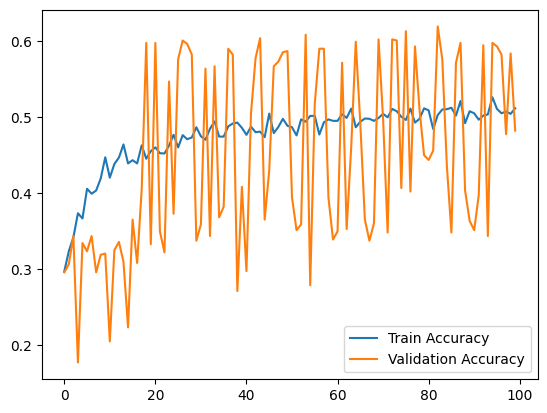

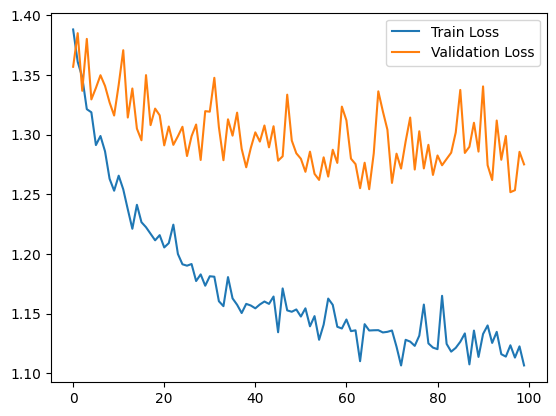

In [9]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [10]:
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 422ms/step - accuracy: 0.5167 - loss: 1.2860
Validation Accuracy: 50.39%


In [11]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Path to one test image
img_path = "/content/leukemia/Segmented/Early/WBC-Malignant-Early-001.jpg" #now i take a image from Early dataset, for check it work or not

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
pred = model.predict(img_array)
class_labels = list(train_gen.class_indices.keys())
print("Predicted Class:", class_labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
Predicted Class: Early


In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Get predictions for validation set
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step
Confusion Matrix:
 [[  0  13  36  51]
 [  0  38  59 100]
 [  0  26  62 104]
 [  0  36  42  82]]
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00       100
       Early       0.34      0.19      0.25       197
         Pre       0.31      0.32      0.32       192
         Pro       0.24      0.51      0.33       160

    accuracy                           0.28       649
   macro avg       0.22      0.26      0.22       649
weighted avg       0.25      0.28      0.25       649



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
